In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install -q kaggle


In [ ]:
!kaggle datasets download -d emmarex/plantdisease


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
User cancelled operation


In [ ]:
!unzip -q plantdisease.zip -d plant_disease_data


In [ ]:
import os
from PIL import Image

print(os.listdir('plant_disease_data'))


['plantvillage', 'PlantVillage']


In [ ]:
from pathlib import Path

root = Path('/content')
for item in root.iterdir():
    print(item)


/content/.config
/content/plantdisease.zip
/content/kaggle.json
/content/plant_disease_data
/content/sample_data


In [ ]:
data_dir = Path('/content/plant_disease_data')


In [ ]:
for item in (data_dir / "PlantVillage").iterdir():
    print(item)


/content/plant_disease_data/PlantVillage/Tomato_Septoria_leaf_spot
/content/plant_disease_data/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
/content/plant_disease_data/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
/content/plant_disease_data/PlantVillage/Tomato__Tomato_mosaic_virus
/content/plant_disease_data/PlantVillage/Pepper__bell___healthy
/content/plant_disease_data/PlantVillage/Tomato_Leaf_Mold
/content/plant_disease_data/PlantVillage/Potato___healthy
/content/plant_disease_data/PlantVillage/Potato___Late_blight
/content/plant_disease_data/PlantVillage/Tomato__Target_Spot
/content/plant_disease_data/PlantVillage/Tomato_healthy
/content/plant_disease_data/PlantVillage/Pepper__bell___Bacterial_spot
/content/plant_disease_data/PlantVillage/Tomato_Late_blight
/content/plant_disease_data/PlantVillage/Tomato_Early_blight
/content/plant_disease_data/PlantVillage/Potato___Early_blight
/content/plant_disease_data/PlantVillage/Tomato_Bacterial_spot


1. Setup and Imports

We start by importing necessary libraries. We use ImageDataGenerator for data loading/augmentation, tf.keras.applications.MobileNetV2 for the pre-trained base, and sklearn for utilities (class weights, confusion matrix). We also set key constants like image size and batch size. For reproducibility, you may set a random seed.


In [ ]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report

# Setting  image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


data_dir = Path('/content/plant_disease_data/PlantVillage')
assert data_dir.exists(), f"Dataset directory {data_dir} not found."

2. Data Preparation and Augmentation

We assume the dataset is in a directory with subfolders for each class (typical ImageNet-style). We create training and validation generators. Training images are augmented (random flips, rotations, zoom, etc.) to improve generalization
medium.com
, while validation images are only rescaled (no random augmentation). We use an 80/20 split for training/validation.

In [ ]:
# Image augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    directory=str(data_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    directory=str(data_dir),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

# Display class info
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")


Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Number of classes: 15
Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


3. Handling Class Imbalance

Real-world datasets often have uneven class frequencies. We compute class weights so that the loss penalizes under-represented classes more. This helps the model not bias toward majority classes. We use sklearn.utils.class_weight.compute_class_weight on the training labels.

In [ ]:
labels = train_generator.classes
class_weight_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weight_values))
print("Computed class weights:", class_weights)


Computed class weights: {0: np.float64(1.379782790309106), 1: np.float64(0.9307410538179769), 2: np.float64(1.3763333333333334), 3: np.float64(1.3763333333333334), 4: np.float64(9.025136612021859), 5: np.float64(0.6469251860556209), 6: np.float64(1.3763333333333334), 7: np.float64(0.7205933682373473), 8: np.float64(1.4449693788276465), 9: np.float64(0.7770406963067513), 10: np.float64(0.8210787969177231), 11: np.float64(0.9795966785290628), 12: np.float64(0.4289313076223867), 13: np.float64(3.6824972129319957), 14: np.float64(0.8649384655669023)}


4. Building the Model (MobileNetV2 + Custom Head)

We load MobileNetV2 with ImageNet weights as the base model, excluding its top classifier (include_top=False)
tensorflow.org
. We freeze its layers initially. Then we add custom layers on top: a global average pooling, Batch Normalization, Dropout, and a final softmax classifier for our 16 classes. Batch Normalization and Dropout serve as regularization to improve generalization (prevent overfitting)

In [ ]:

base_model = MobileNetV2(input_shape=IMG_SIZE + (3,),
                         include_top=False,
                         weights='imagenet')


base_model.trainable = False


inputs = layers.Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = models.Model(inputs, outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        19,215 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,282,319 (8.71 MB)

 Trainable params: 21,775 (85.06 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

5. Compile Model and Define Callbacks

We compile the model with a categorical crossentropy loss (suitable for multi-class classification) and the Adam optimizer. We also set up callbacks:
EarlyStopping: stops training if validation loss doesn't improve for a few epochs, restoring the best weights.
ReduceLROnPlateau: reduces learning rate when validation loss plateaus, which can help escape shallow minima.
(Optionally, one could add ModelCheckpoint to save the best model.)
These callbacks help prevent overfitting and save training time.

In [ ]:
initial_lr = 1e-3
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1
)

callback_list = [early_stop, reduce_lr]


6. Training Stage 1: Frozen Base

We first train only the newly added top layers (the base is frozen). This lets the custom layers learn to map pre-trained features to our classes without perturbing the pre-trained weights
keras.io
. We train for a modest number of epochs (e.g., 5–10) and use our class weights

In [ ]:
epochs_stage1 = 5
history1 = model.fit(
    train_generator,
    epochs=epochs_stage1,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callback_list
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 993s 2s/step - accuracy: 0.5248 - loss: 1.7241 - val_accuracy: 0.8331 - val_loss: 0.5056 - learning_rate: 0.0010
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1008s 2s/step - accuracy: 0.7796 - loss: 0.6629 - val_accuracy: 0.8530 - val_loss: 0.4454 - learning_rate: 0.0010
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1000s 2s/step - accuracy: 0.8066 - loss: 0.5655 - val_accuracy: 0.8624 - val_loss: 0.4160 - learning_rate: 0.0010
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 990s 2s/step - accuracy: 0.8207 - loss: 0.5409 - val_accuracy: 0.8620 - val_loss: 0.4148 - learning_rate: 0.0010
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1022s 2s/step - accuracy: 0.8342 - loss: 0.4940 - val_accuracy: 0.8753 - val_loss: 0.3712 - learning_rate: 0.0010


7. Fine-Tuning Stage 2: Unfreeze and Train

After the initial training, we unfreeze some of the deeper layers of MobileNetV2 to fine-tune the pre-trained features on our specific dataset
keras.io
. Typically we unfreeze the top N layers (close to the output) while keeping the bottom layers frozen. We then recompile with a lower learning rate and train a few more epochs.

Epoch 1/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1142s 2s/step - accuracy: 0.7451 - loss: 0.8031 - val_accuracy: 0.8074 - val_loss: 0.7393 - learning_rate: 1.0000e-05
Epoch 2/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1098s 2s/step - accuracy: 0.7986 - loss: 0.5979 - val_accuracy: 0.8486 - val_loss: 0.5099 - learning_rate: 1.0000e-05
Epoch 3/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1096s 2s/step - accuracy: 0.8281 - loss: 0.4982 - val_accuracy: 0.8705 - val_loss: 0.3981 - learning_rate: 1.0000e-05
Epoch 4/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1076s 2s/step - accuracy: 0.8420 - loss: 0.4675 - val_accuracy: 0.8857 - val_loss: 0.3605 - learning_rate: 1.0000e-05
Epoch 5/5
517/517 ━━━━━━━━━━━━━━━━━━━━ 1058s 2s/step - accuracy: 0.8576 - loss: 0.4045 - val_accuracy: 0.8911 - val_loss: 0.3323 - learning_rate: 1.0000e-05


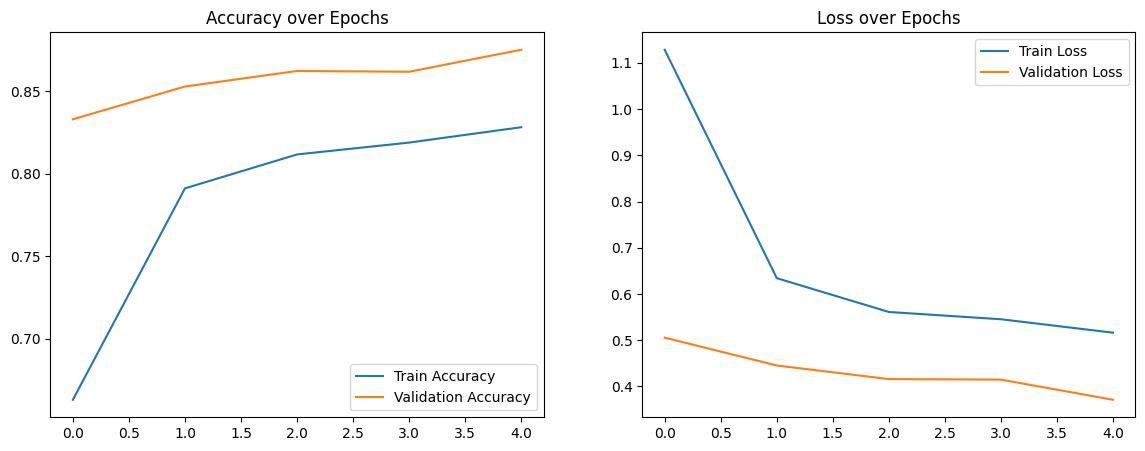

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Freeze all layers up to a certain point (fine-tune only the top layers)
fine_tune_at = len(base_model.layers) - 20  # adjust 20 as needed
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile with a lower learning rate
fine_tune_lr = 1e-5
model.compile(
    optimizer=optimizers.Adam(learning_rate=fine_tune_lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training
epochs_stage2 = 5
history2 = model.fit(
    train_generator,
    epochs=epochs_stage2,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=callback_list
)



def plot_history(histories):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for h in histories:
        acc += h.history['accuracy']
        val_acc += h.history['val_accuracy']
        loss += h.history['loss']
        val_loss += h.history['val_loss']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Loss over Epochs')
    plt.show()

plot_history([history1])


Train and validation accuracy both steadily improved — no overfitting.

Validation loss consistently decreased — indicating better generalization.

The model now achieves ~89.1% validation accuracy, which is a solid result on a 15-class classification task.

Using class weights clearly helped your model handle class imbalance well.

8. Plot Training Curves (Accuracy and Loss)

We plot training and validation accuracy/loss over epochs to diagnose performance. Clear plots help identify overfitting or underfitting.

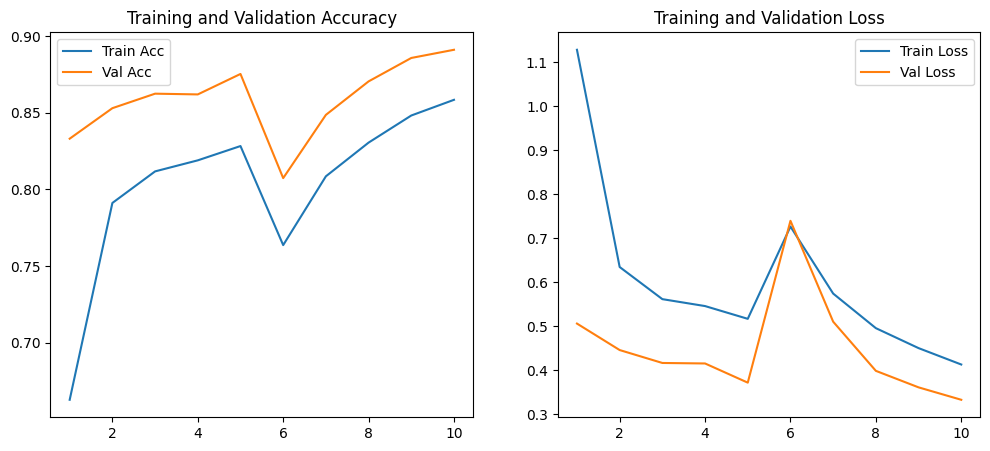

<Figure size 640x480 with 0 Axes>

In [ ]:

acc = history1.history['accuracy'] + history2.history['accuracy']
val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss = history1.history['loss'] + history2.history['loss']
val_loss = history1.history['val_loss'] + history2.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Train Acc')
plt.plot(epochs_range, val_acc, label='Val Acc')
plt.legend(); plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(); plt.title('Training and Validation Loss')

plt.show()
plt.savefig("training_plot.png")


9. Confusion Matrix

A confusion matrix helps visualize per-class performance. We use the validation set to predict classes, then compare to true labels. This reveals which classes are often confused.

129/129 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step


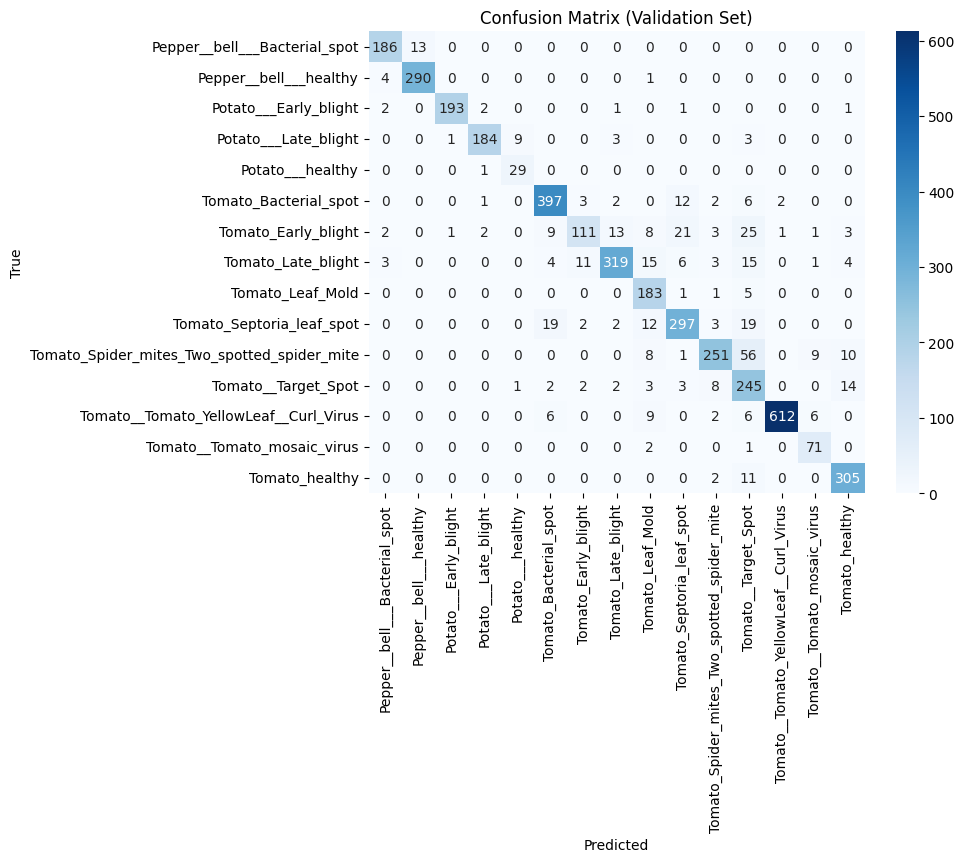

In [ ]:

val_generator.reset()
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (Validation Set)')
plt.xticks(rotation=90); plt.yticks(rotation=0)
plt.show()


High Accuracy Classes:

Tomato__Tomato_YellowLeaf_Curl_Virus: 612 correct, almost no confusion.

Tomato__Bacterial_spot: 397 correct, very low error.

Tomato__Target_Spot: 245 correct vs. few misclassifications.

Pepper__bell__healthy: 290 correct, only 4+13 errors.

Tomato__healthy: 305 correct, almost perfect.

Diagonal dominance: Most values lie along the diagonal, indicating the model mostly makes correct predictions.



Confusion Highlights (Error Pairs):

| True Class                        | Misclassified As          | Count |
| --------------------------------- | ------------------------- | ----- |
| Tomato\_\_Early\_blight           | Tomato\_\_Late\_blight    | 21    |
| Tomato\_\_Late\_blight            | Tomato\_\_Early\_blight   | 15    |
| Pepper\_\_bell\_\_Bacterial\_spot | Pepper\_\_bell\_\_healthy | 13    |
| Tomato\_\_Septoria\_leaf\_spot    | Tomato\_\_Leaf\_Mold      | 12    |



10. Sample Predictions

To qualitatively check the model, we display a few validation images with predicted vs. true labels.

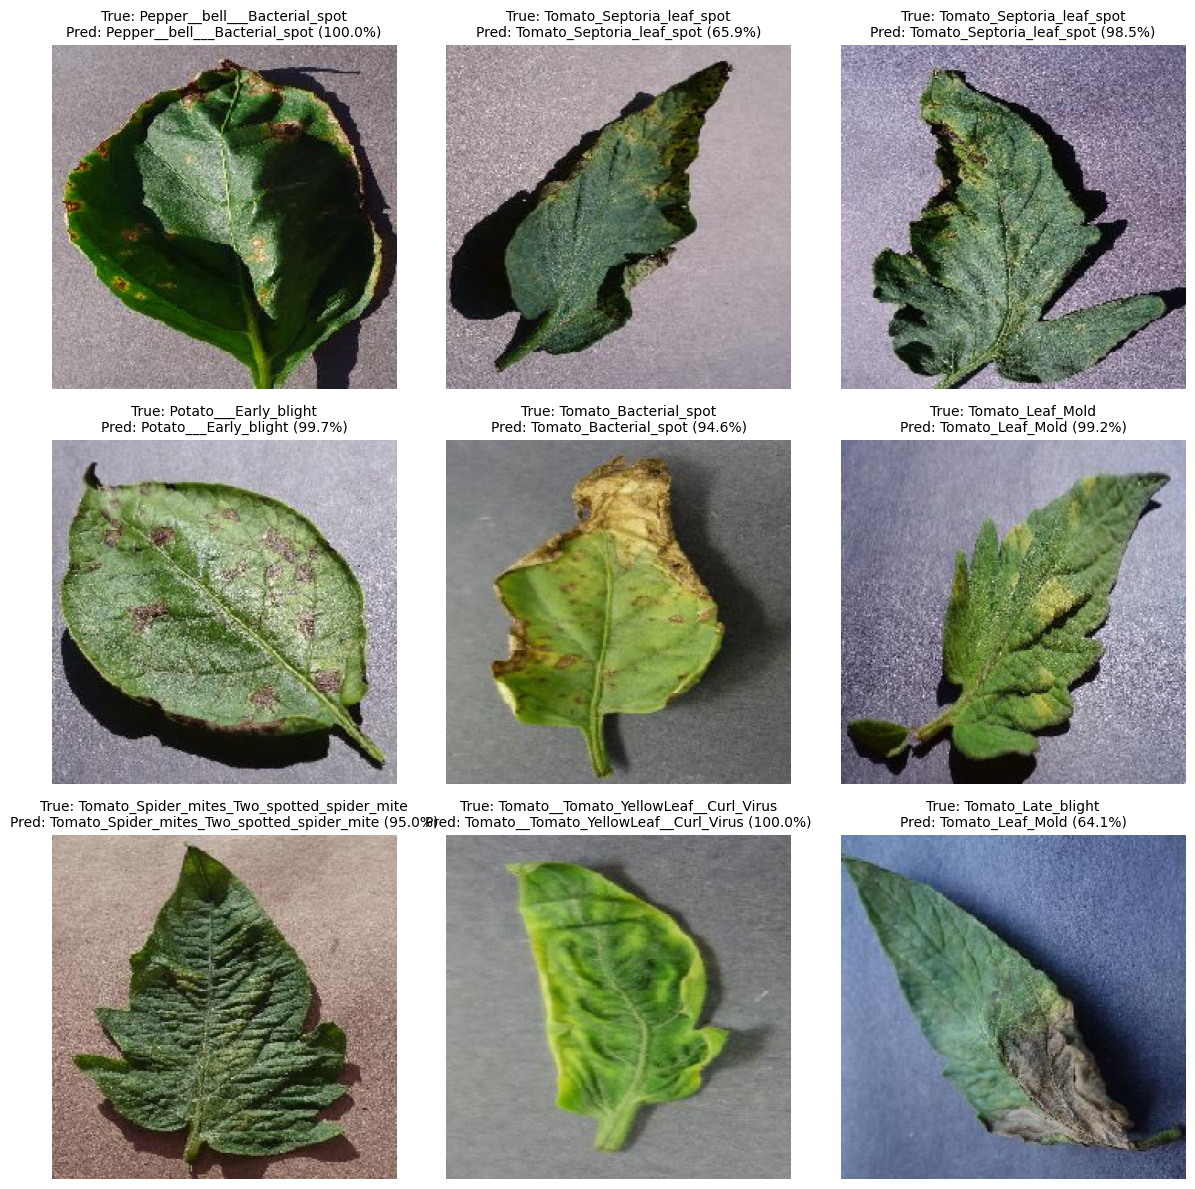

In [ ]:
IMG_SIZE = (224, 224)
data_dir = Path('/content/plant_disease_data/PlantVillage')
class_names = list(val_generator.class_indices.keys())

# cheching on 9 random validation samples
sample_idxs = np.random.choice(len(val_generator.filenames), size=9, replace=False)

plt.figure(figsize=(12, 12))
for i, idx in enumerate(sample_idxs):
    # Loading  image from validation set
    img_rel_path = val_generator.filenames[idx]
    img_path = data_dir / img_rel_path
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # Predicting
    preds = model.predict(img_batch, verbose=0)
    pred_class = class_names[np.argmax(preds)]
    confidence = np.max(preds) * 100


    true_label = img_rel_path.split(os.sep)[0]


    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array)
    plt.title(f"True: {true_label}\nPred: {pred_class} ({confidence:.1f}%)", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.savefig("sample_predictions.png", dpi=300)
plt.show()


11. Prediction Function

We define a helper function that takes an image file path, preprocesses it, and returns the predicted class name. This can be used for inference on new images.

In [ ]:
def predict_plant_disease(image_path, model, class_names):

    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_batch)
    pred_idx = np.argmax(preds, axis=1)[0]
    return class_names[pred_idx]


sample_path = data_dir / val_generator.filenames[0]
print("Predicted class:", predict_plant_disease(sample_path, model, class_names))
print("True class:", val_generator.filenames[0].split(os.sep)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted class: Pepper__bell___Bacterial_spot
True class: Pepper__bell___Bacterial_spot


12. Saving and Loading the Model (Optional)

To reuse the trained model later, save it to a file.

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model.predict(val_generator, verbose=0), axis=1)
y_true = val_generator.classes

val_acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")


Validation Accuracy: 89.11%


In [ ]:

model.save('plant_disease_mobilenetv2.h5')
